Assignment Group -

Sanket Potdar (20D070071)

Simran Tanwar (20D070078)

In [ ]:
#importing Libraries
from google.colab.patches import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy import ndimage
import pywt
import pywt.data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Q1. Write the following basic functions using numpy and scipy signal libraries only in an efficient manner:

In [ ]:
img = cv2.imread('/content/drive/MyDrive/EE610/Assignment3/DSC_0363.JPG') #to read image
cv2_imshow(img) #to display the image

#We would also require a gray test image to see if our code works on gray image
vin = cv2.imread('/content/drive/MyDrive/EE610/Assignment3/Vintage.jpg')
gray = cv2.cvtColor( vin, cv2.COLOR_BGR2GRAY )
cv2_imshow(gray)

img2 = cv2.imread('/content/drive/MyDrive/EE610/Assignment3/image.jpeg')
cv2_imshow(img2) #to display the image

#We would also require a gray test image to see if our code works on gray image
lon = cv2.imread('/content/drive/MyDrive/EE610/Assignment3/image.jpeg')
gray2 = cv2.cvtColor( lon, cv2.COLOR_BGR2GRAY )
cv2_imshow(gray2)


# a. Add additive white Gaussian noise (AWGN) with variable variance to any given image, whether grayscale or color.

In [ ]:
def Gaussian(image,var): # variance is same for 3 different RGB channels
  mean = 0 # mean for white noise is always 0
  sigma = var**0.5

  if image.ndim == 3: # i.e. if the image has dimension 3 -> image is coloured #ndim source - Numpy Docs
    row,col,ch = image.shape #we treat all 3 channels or RGB independently
    gauss = np.random.normal(mean,sigma,(row,col,ch)) #Source - Numpy Docs
    gauss = gauss.reshape(row,col,ch) #just to ensure that noise has the same shape as the image

  if image.ndim == 2: # i.e. if the image has dimension 2 -> image is grayscale # ndim source - Numpy Docs
    row,col = image.shape 
    gauss = np.random.normal(mean,sigma,(row,col)) #Source - Numpy Docs
    gauss = gauss.reshape(row,col) #just to ensure that noise has the same shape as the image

  gaussian = np.clip((image + gauss),0,255) #clip the image pixel intensities between 0-255
  return gaussian

cv2_imshow(Gaussian(img,100)) #coloured image
cv2_imshow(Gaussian(gray,1000)) #grayscale image - requires more variance as image is bright, so difficult to notice AWGN with low variance

We use np.random.normal for normal distribution with attributes mean, standard deviation and size, to create white gaussian noise with mean 0 and variable variance defined in the function. While outputting, we clip the intensity values from 0 to 255. We first divide the grayscale and coloured images using their difference in dimensions, i.e. 2 & 3 using if statement. Also we deal separately with 3 different channels for colour images. We can see the noisy output clearly.

We also observe that as we increase the variance, the noise increases

# b. Measure PSNR (with 255 as the default peak, but it should also be variable) between a restored image and a ground-truth image.

PSNR = 10log((L-1)^2/MSE) = 20log((L-1)/RMSE) where L is the number of maximum possible intensity levels. 

RMSE - Root Mean Squared Error is calculated between our restored image and original image. 

Our function returns the value of PSNR in dB. For similar images with 0 noise, our function returns infinity. We set the default value of max = 255, but it can be varied too while executing the function.

In [ ]:
def PSNR(orig,restored,max=255): #for 8 bit images, value of max = 255 
  error = orig - restored
  mse = np.mean((error) ** 2) #np.mean -> Source - Numpy Docs
  if mse == 0:
        return float('inf') #if the mse = 0, the output should be infinity as the noise is 0
  psnr = 10*math.log((max**2)/mse,10) #using the formula above
  return psnr

print(PSNR(gray,Gaussian(gray,100),255)) #printing PSNR between our degraded and original grayscale image
print(PSNR(gray,gray,255)) #printing PSNR between same image should give infinity

28.295319471060623
inf


# c. Measure SSIM (with power 1 for all three elements -- mean, variance, correlation -- which can be varied too) between a restored and a ground-truth image.

SSIM Index quality assessment index is based on the computation of three factors; luminance (l), contrast (c) and structure (s). 

#SSIM = [l(x,y)]^α * [c(x,y)]^β * [s(x,y)]^γ

we assume default value of α, β, γ = 1 as given in question but they can be varied.

where 

l(x,y) = (2 μx μy + C1)/(μx^2 + μy^2 + C1)

c(x,y) = (2 σx σy + C2)/(σx^2 + σy^2 + C2)

s(x,y) = (σxy + C3)/(σx σy + C3)

where μx, μy, σx,σy, and σxy are the local means, standard deviations, and cross-covariance for images x, y.
If α = β = γ = 1 and C3 = C2/2 (both common assumptions) the equation simplifies to:

SSIM = (2 μx μy + C1)(2 σx σy + C2)/(μx^2 + μy^2 + C1)(σx^2 + σy^2 + C2)

The SSIM values range between 0 to 1 where 1 means a perfect match between the original image and the copy.

#Method - 1 : Using OpenCV 

Reference - CVNotes

In [ ]:
def SSIM(orig,restored,p_l=1,p_c=1,p_s=1,L=255): #setting default value of α = β = γ = 1
  #assuming 8-bit image with L = 255
  C1 = (0.01 * L)**2 
  C2 = (0.03 * L)**2
  C3 = 0.5 * C2 #taking common assumption of C3 = 0.5*C2 for simplification
  orig = orig.astype(np.float64)
  restored = restored.astype(np.float64) #ensuring both images are of same float type

  #We need to define a 11*11 gaussian window to find the local mean and variances
  #First, we create an approximate 1D gaussian kernel using cv2.getGaussiankernel with attributes (Aperture size,sigma)
  #We take the value of sigma = 1.5 and size of gaussian kernel = 11
  kernel = cv2.getGaussianKernel(11, 1.5) #Source -> OpenCV Docs 
  window = np.outer(kernel, kernel.transpose()) #source -> OpenCV Docs
  #np.outer mutliplies all elements of two arrrays in attributes in pairs
  #thus we get an approximated gaussian window of size 11 x 11 with sigma = 1.5

  # cv2.filter2D - Source -> OpenCV Docs
  # cv2.filter2D - Function to perform convolution of an image with a 2D matrix 
  # 3 attributes (source image, depth of output image, kernel)
  # When depth = -1, it takes the same value of depth as the source image
  # kernel -2d matrix we want the image to convolve with, i.e., 11x11 Gaussian window in our case
  # mean = sum/N
  mux = cv2.filter2D(orig, -1, window)[5:-5, 5:-5] # local mean(μx) of our original 
                                                   # image by convolving with our kernel 
  muy = cv2.filter2D(restored, -1, window)[5:-5, 5:-5] # local mean(μy) of our restored 
                                                       # image by convolving with our kernel
  mux_sq = mux**2 #μx^2
  muy_sq = muy**2 #μy^2

  #variance = sum(X^2)/N - mu^2
  sigmax_sq = cv2.filter2D(orig**2, -1, window)[5:-5, 5:-5] - mux_sq #variance σx^2 
  sigmay_sq = cv2.filter2D(restored**2, -1, window)[5:-5, 5:-5] - muy_sq ##variance σy^2
  sigmaxy = cv2.filter2D(orig * restored, -1, window)[5:-5, 5:-5] - (mux*muy) ##crossvariance σxy
  
  sigmax = np.sqrt(np.abs(sigmax_sq)) #Standard deviation - σx
  sigmay = np.sqrt(np.abs(sigmay_sq)) #Standard deviation - σy

  #defining values of l,c and s
  l = (2*mux*muy + C1)/(mux_sq + muy_sq + C1)
  c = (2*sigmax*sigmay + C2)/(sigmax_sq + sigmay_sq + C2)
  s = (sigmaxy + C3)/(sigmax*sigmay + C3)
  
  ssim = ((l**(p_l))*(c**(p_c))*(s**(p_s)))
  
  #Now we need to define SSIM separately for grayscale and RGB images
  if orig.shape != restored.shape:
    raise ValueError('Images must have the same dimensions.')
  if orig.ndim == 2: #if images are grayscale, i.e, they only have rows and columns and no RGB channels
    return ssim.mean()
  elif orig.ndim == 3:
    if orig.shape[2] == 3: #image is RGB - 3 channels
      ssimc = []
      for i in range(3): 
        ssimc.append(SSIM(np.squeeze(orig[:,:,i]),np.squeeze(restored[:,:,i]),p_l,p_c,p_s)) #dealing with RGB channels 
                                                                                            #separately and appending the value to the array
        #np.squeeze() - Source -> OpenCV Docs - Reduces the dimension of the input array by 1
      return ssimc,np.sum(ssimc)/3 #we calculate the ssim for 3 channels separately and also compute its average
  

In [ ]:
print(SSIM(gray,Gaussian(gray,100))) #Check for grayscale images
print(SSIM(img,Gaussian(img,10))) #Check for coloured images returning the SSIM for RGB channel and also their average
print(SSIM(gray,gray)) #check for 2 similar images
print(SSIM(img,Gaussian(img,200)))

0.592778560951368
([0.8719217804324458, 0.8699954002668743, 0.8713709444805677], 0.8710960417266292)
1.0
([0.2810315655054698, 0.27788646319674054, 0.2835313492105522], 0.2808164593042542)


We observe that, the value of SSIM increases as we decrease the gaussian blurring effect and it gives output exactly 1, when two same images are inputed. Thus my code is entirely correct :) Finally.

#Method - 2: Using scipy signal
Source -> https://github.com/mubeta06/python/blob/master/signal_processing/sp/ssim.py

The difference between method-1 and method-2 is just that, instead of convolving with cv2.filter2D, we use signal.fftconvolve to calculate the means and variances.

In [ ]:
def SSIM_sci(orig,restored,p_l=1,p_c=1,p_s=1,L=255): #setting default value of α = β = γ = 1
  #assuming 8-bit image with L = 255
  C1 = (0.01 * L)**2 
  C2 = (0.03 * L)**2
  C3 = 0.5 * C2 #taking common assumption of C3 = 0.5*C2 for simplification
  orig = orig.astype(np.float64)
  restored = restored.astype(np.float64) #ensuring both images are of same float type

  #We take the value of sigma = 1.5 and size of gaussian kernel = 11
  kernel = cv2.getGaussianKernel(11, 1.5) #Source -> OpenCV Docs 
  window = np.outer(kernel, kernel.transpose()) #source -> OpenCV Docs
  #np.outer mutliplies all elements of two arrrays in attributes in pairs
  #thus we get a gaussian window of size 11 x 11 with sigma = 1.5

  # signal.fftconvolve -> Performs convolution of our input image with an input 2D matrix
  # kernel-2d matrix we want the image to convolve with, i.e., 11x11 Gaussian window in our case
  # mean = sum/N
  mux = signal.fftconvolve(window, orig, mode='valid') # local means(μx) of our original image                                                 
  muy = signal.fftconvolve(window, restored, mode='valid') # local means(μy) of our restored image

  mux_sq = mux**2 #μx^2
  muy_sq = muy**2 #μy^2

  #variance = sum(X^2)/N - mu^2
  sigmax_sq = signal.fftconvolve(window, orig**2, mode='valid') - mux_sq #variance σx^2 
  sigmay_sq = signal.fftconvolve(window, restored**2, mode='valid') - muy_sq ##variance σy^2
  sigmaxy = signal.fftconvolve(window, orig*restored, mode='valid') - (mux*muy) ##crossvariance σxy
  
  sigmax = np.sqrt(np.abs(sigmax_sq)) #Standard deviation - σx
  sigmay = np.sqrt(np.abs(sigmay_sq)) #Standard deviation - σy

  #defining values of l,c and s
  l = (2*mux*muy + C1)/(mux_sq + muy_sq + C1)
  c = (2*sigmax*sigmay + C2)/(sigmax_sq + sigmay_sq + C2)
  s = (sigmaxy + C3)/(sigmax*sigmay + C3)
  
  ssim = ((l**(p_l))*(c**(p_c))*(s**(p_s)))
  
  #Now we need to define SSIM separately for grayscale and RGB images
  if orig.shape != restored.shape:
    raise ValueError('Images must have the same dimensions.')
  if orig.ndim == 2: #if images are grayscale, i.e, they only have rows and columns and no RGB channels
    return ssim.mean()
  elif orig.ndim == 3:
    if orig.shape[2] == 3: #image is RGB - 3 channels
      ssimc = []
      for i in range(3): 
        ssimc.append(SSIM_sci(np.squeeze(orig[:,:,i]),np.squeeze(restored[:,:,i]),p_l,p_c,p_s)) #dealing with RGB channels 
                                                                                            #separately and appending the value to the array
        #np.squeeze() - Source -> OpenCV Docs - Reduces the dimension of the input array by 1
      return ssimc,np.sum(ssimc)/3 #we calculate the ssim for 3 channels separately and also compute its average
  

In [ ]:
print(SSIM_sci(gray,Gaussian(gray,100))) #Check for grayscale images
print(SSIM_sci(gray,gray)) #check for 2 similar images

0.592716064453719
1.0


#d.Isotropic Gaussian blurring (Gaussian low pass filtering) of an image for a given variance.

To approach the given problem, we first have to create a gaussian blurr window for given variance and then convolve it with the image using cv2.filter2D function. To create the Gaussian window, we use np.linspace to create 2 1D arrays of kernel_size (default set to 5) and use np.meshgrib to create a 2D Gaussian window of given kernel_size.

There are 3 ways for find the Gaussian kernel, one of which is used above-

Method - 1: Using cv2.getGaussianKernel and np.outer

In [ ]:
def gauss_1(k_size,sigma):
  #First, we create an approximate 1D gaussian kernel using cv2.getGaussiankernel with attributes (Aperture size,sigma)
  k_1 = cv2.getGaussianKernel(k_size, sigma) 
  w_1 = np.outer(k_1, k_1.transpose())
  #np.outer mutliplies all elements of two arrrays in attributes in pairs
  #thus we get an approximated gaussian window of size 11 x 11 with sigma = 1.5
  return(w_1)

Method - 2: Using Gaussian formula and np.outer

Source - Stackoverflow.com

In [ ]:
  def gauss_2(k_size,sigma):
    #Create a 1D array from -(k_size - 1) / 2. to (k_size - 1) / 2. in steps of k_size
    # np.linspace() -> creates a vector of given size between given interval
    x = np.linspace(-(k_size - 1) / 2., (k_size - 1) / 2., k_size)
    #Write the expression for Gaussian function in 1D
    g_2 = np.exp(-0.5 * np.square(x) / np.square(sigma))
    #Use np.outer to create 2D window
    k_2 = np.outer(g_2, g_2) 
    return k_2 / np.sum(k_2) #Normalizing the kernel

Method - 3: Using np.meshgrid and Gaussian formula

Source - GeekforGeeks.com

In [ ]:
  def gauss_3(k_size,sigma):
    x, y = np.meshgrid(np.linspace(-1, 1, k_size),  #source - OpenCV Docs
                       np.linspace(-1, 1, k_size))
    # np.linspace() -> creates a vector of given size between given interval
    # We create a 2D array using np.meshgrid where 
    #x -> kernel with size k_size*k_size and each row from -1 to 1 with k_size elements at equal intervals
    #y -> kernel with size k_size*k_size and each column from -1 to 1 with k_size elements at equal intervals
    dist = np.sqrt(x**2 + y**2)  #distance from centre is defined here 
    #The maximum distance is 1 as we have taken range of x,y from [-1,1]

    # Calculating Gaussian filter - Apply the gaussian formula
    g_3 = (1/np.sqrt(2*np.pi*(sigma**2)))*np.exp(-((dist)**2 / (2.0 * (sigma**2)))) # Here we assume mean to be 0
    g_3 = g_3/np.sum(g_3) #Normalizing the kernel so thats its adds upto 1
    return g_3

Now comparing all the methods for kernel size = 3 and sigma =1

In [ ]:
print(gauss_1(3,1))
print(gauss_2(3,1))
print(gauss_3(3,1))

#We observe that all 3 gives same output

[[0.07511361 0.1238414  0.07511361]
 [0.1238414  0.20417996 0.1238414 ]
 [0.07511361 0.1238414  0.07511361]]
[[0.07511361 0.1238414  0.07511361]
 [0.1238414  0.20417996 0.1238414 ]
 [0.07511361 0.1238414  0.07511361]]
[[0.07511361 0.1238414  0.07511361]
 [0.1238414  0.20417996 0.1238414 ]
 [0.07511361 0.1238414  0.07511361]]


#Final d.

In [ ]:
def gauss_blurr(image, var, k_size = 11):
  sigma = np.sqrt(var)
  
  #finding the gaussian blurr kernel
  gauss = gauss_3(k_size,sigma)
  
  #Now we have our gaussian kernel ready
  #Next, we convolve the window with the image
  out = cv2.filter2D(image, -1, gauss)
  return out

In [ ]:
cv2_imshow(Gaussian(gray,2000))
gray_gauss = Gaussian(gray,2000)
cv2_imshow(gauss_blurr(gray_gauss,5,11))

cv2_imshow(Gaussian(img,2000))
img_gauss = Gaussian(img,2000)
cv2_imshow(gauss_blurr(img_gauss,5,11))

We observe noticeable difference between our noisy image and smoothened image. The noise is significantly reduced, but the image gets blurred.

# 2. Write the following denoising functions for wavelet transforms

Displaying the output of our DWT using db4 wavelet

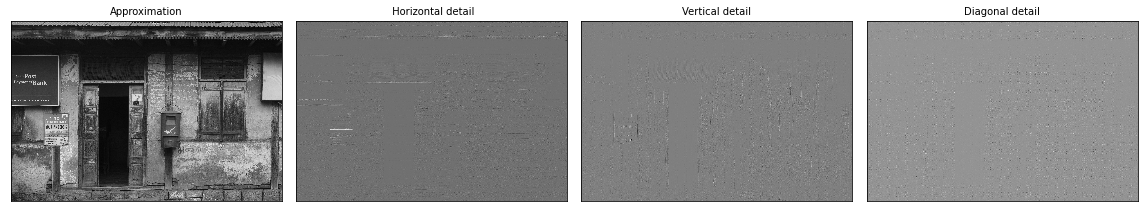

In [ ]:
coeffs2 = pywt.dwt2(gray, 'db4')
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
LL1, (LH1, HL1, HH1) = coeffs2
fig = plt.figure(figsize=(16, 4))
for i, a in enumerate([LL1, LH1, HL1, HH1]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()

We could clearly see the horizontal and vertical details in the LH and HL coefficients and little bit of diagonal details in the HH coefficients

In [ ]:
  print(LH1)
  LH1[abs(LH1)<2] = 0 #sets all the values in LH below the threshold to 0
  print("after hard")
  print(LH1)
  LH1[LH1>2]-=2
  LH1[LH1<-2]+=2
  print("after soft")
  print(LH1)

[[ 0.96130813  1.86734907  3.02275223 ...  1.7592055   0.07582025
  -0.68361067]
 [ 1.00535252  2.97898646  5.69326046 ...  3.15256694  0.6322259
  -0.60488858]
 [16.96309077 14.44256724  8.79325816 ... -3.81299229 -0.77781285
   0.52907519]
 ...
 [ 0.03563437 -0.12675107  2.79940477 ... -1.01925248 -2.47304331
  -2.44987326]
 [ 0.83736845  1.34721927  9.37662236 ... -2.89959032 -6.01918469
  -5.67351608]
 [-1.04911159 -1.83848437 -5.19046729 ...  1.87548024  3.69731987
   4.00944828]]
after hard
[[ 0.          0.          3.02275223 ...  0.          0.
   0.        ]
 [ 0.          2.97898646  5.69326046 ...  3.15256694  0.
   0.        ]
 [16.96309077 14.44256724  8.79325816 ... -3.81299229  0.
   0.        ]
 ...
 [ 0.          0.          2.79940477 ...  0.         -2.47304331
  -2.44987326]
 [ 0.          0.          9.37662236 ... -2.89959032 -6.01918469
  -5.67351608]
 [ 0.          0.         -5.19046729 ...  0.          3.69731987
   4.00944828]]
after soft
[[ 0.          0.  

#a. Hard thresholding: set to zero any detail (LH, HL, HH) coefficient that is below a threshold (threshold should be variable)

In [ ]:
# A function defined for hard thresholding
def hardThreshold(image,th): #th is the threshold used
  #ideally threshold λ = 𝜎*sqrt(2*log2(l*w)) where 𝜎^2 = variance of noise in AWGN defined above
  #first we take the DWT of image 
  #pywt.dwt2 Source -> PyWavelets Docs
  coeffsh = pywt.dwt2(image, 'db4') #we use the direct function for dwt in 2D - dw2
  #we compute the DWT with db4 wavelet as it performs better as compared to haar 
  #the output is a tuple containing the Approximation, horizontal detail, 
  #vertical detail and diagonal detail coefficients respectively.
  LL, (LH, HL, HH) = coeffsh
  
  #Applying hard thresholding
  LH[abs(LH)<th] = 0 #sets all the values in LH below the threshold to 0
  HL[abs(HL)<th] = 0 #sets all the values in HL below the threshold to 0
  HH[abs(HH)<th] = 0 #sets all the values in HH below the threshold to 0
  
  #defining the coefficients after thresholding
  hard_coeffs = LL, (LH, HL, HH)
  #performing IDWT in 2D using idwt2
  #pywt.idwt2 Source -> PyWavelets Docs
  ht = pywt.idwt2(hard_coeffs, 'db4')
  htf = np.clip(ht,0,255) #clip the image pixel intensities between 0-255

  #Now differentiating between grayscale and colour images

  #We differentiate them on the basis of their dimensions as done in SSIM
  if image.ndim == 2: #if images are grayscale, i.e, they only have rows and columns and no RGB channels
    return htf #returning the thresholded grayscale image
  elif image.ndim == 3:
    if image.shape[2] == 3: #image is RGB - 3 channels
      htf1 = hardThreshold(image[:,:,0],th)
      htf2 = hardThreshold(image[:,:,1],th)
      htf3 = hardThreshold(image[:,:,2],th)
      #dealing with RGB channels separately

      #Source -> Numpy Docs
      htfc = np.dstack((htf1,htf2,htf3)) #np.dstack -> to stack r,g,b channels to create RGB image
      return htfc
      #returning the thresholded colour image

In [ ]:
var = 1000
nsig = math.sqrt(var)
print(gray.shape)
print(gray.size)
thresh = nsig*math.sqrt(2*math.log2(gray.size)) 
#finding the threshold λ = 𝜎*sqrt(2*log2(l*w)) where 𝜎^2 = variance of noise in AWGN defined above
#suggested by Donoho et al.
print(thresh)
ht_gray = hardThreshold(Gaussian(gray,var),thresh) #hardthresholding the noisy image
#comparing the two images
cv2_imshow(Gaussian(gray,var)) 
cv2_imshow(ht_gray)
print(ht_gray[:,:-1]-Gaussian(gray,var)) 

We dont see any noticeable difference in with the given value of threshold, we find the difference between the thresholded and noisy image. Also the column length of the image after taking IDWT increases by 1, we only take the first rws,cols-1 pixels to make the array sizes of ht_gray and noisy gray image equal. We observe that they are not equal and have noticeable difference. 

Now, to observe a noticeable difference in our images, we increase the threshold from about 219 to 350 and observe the the noise reduces significantly

In [ ]:
cv2_imshow(Gaussian(gray,var)) 
cv2_imshow(hardThreshold(Gaussian(gray,var),350))

We test out code for colour image and see noticeable result. Our coloured image gets significantly denoised with our function, but also gets blurred to some extent.

In [ ]:
cv2_imshow(Gaussian(img,var))
cv2_imshow(hardThreshold(Gaussian(img,var),thresh))

#b. Soft threhsolding: set to zero any detail (LH, HL, HH) coefficient that is below a threshold and subtract the threshold from those that are above the threshold.

In [ ]:
# A function defined for soft thresholding
def softThreshold(image,th): #th is the threshold used
  #ideally threshold λ = 𝜎*sqrt(2*log2(l*w)) where 𝜎^2 = variance of noise in AWGN defined above
  #first we take the DWT of image
  #pywt.dwt2 Source -> PyWavelets Docs
  coeffss = pywt.dwt2(image, 'db4') #we use the direct function for dwt in 2D - dw2
  #we compute the DWT with db4 wavelet as it performs better as compared to haar 
  #the output is a tuple containing the Approximation, horizontal detail, 
  #vertical detail and diagonal detail coefficients respectively.
  LL, (LH, HL, HH) = coeffss
  
  #Applying soft thresholding
  LH[abs(LH)<th] = 0 #sets all the values in LH below the threshold to 0
  HL[abs(HL)<th] = 0 #sets all the values in HL below the threshold to 0
  HH[abs(HH)<th] = 0 #sets all the values in HH below the threshold to 0

  #Subtracting the threshold from remaining values
  #We add threshold to negative values of coeff and subtract for positive coefficients
  LH[LH>th]-=th
  LH[LH<-th]+=th

  HL[HL>th]-=th
  HL[HL<-th]+=th
  
  HH[HH>th]-=th
  HH[HH<-th]+=th

  #defining the coefficients after thresholding
  soft_coeffs = LL, (LH, HL, HH)
  
  #performing IDWT in 2D using idwt2
  #pywt.idwt2 Source -> PyWavelets Docs
  st = pywt.idwt2(soft_coeffs, 'db4')
  stf = np.clip(st,0,255) #clip the image pixel intensities between 0-255

  #Now differentiating between grayscale and colour images

  #We differentiate them on the basis of their dimensions as done in SSIM
  if image.ndim == 2: #if images are grayscale, i.e, they only have rows and columns and no RGB channels
    return stf #returning the thresholded grayscale image
  elif image.ndim == 3:
    if image.shape[2] == 3: #image is RGB - 3 channels
      stf1 = softThreshold(image[:,:,0],th)
      stf2 = softThreshold(image[:,:,1],th)
      stf3 = softThreshold(image[:,:,2],th)
      #dealing with RGB channels separately

      #Source -> Numpy Docs
      stfc = np.dstack((stf1,stf2,stf3)) #np.dstack -> to stack r,g,b channels to create RGB image
      return stfc
      #returning the thresholded colour image

In [ ]:
vars = 1000
nsigs = math.sqrt(vars)
threshs = nsigs*math.sqrt(2*math.log2(gray.size)) 
#finding the threshold λ = 𝜎*sqrt(2*log2(l*w)) where 𝜎^2 = variance of noise in AWGN defined above
#suggested by Donoho et al.
print(threshs)
st_gray = softThreshold(Gaussian(gray,vars),threshs) #softthresholding the noisy image
#comparing the two images
cv2_imshow(Gaussian(gray,vars)) 
cv2_imshow(st_gray)

In [ ]:
cv2_imshow(Gaussian(gray,vars)) 
cv2_imshow(softThreshold(Gaussian(gray,vars),400))

Checking our code for coloured images - It works successfully : ) and we see less noise in our output image : )

In [ ]:
cv2_imshow(Gaussian(img,vars)) 
cv2_imshow(softThreshold(Gaussian(img,vars),threshs))

#c. The method proposed in the paper “Image Denoising using Neighbouring Wavelet Coefficients” by Chen et al.

Defining a function for Zero-padding (dealing with grayscale and RGB separately)

In [ ]:
def zeroPadding0(image,d=1):
  L = image.shape[0]
  W = image.shape[1]
  if image.ndim == 2: #if images are grayscale, i.e, they only have rows and columns and no RGB channels
    zeroPad = np.zeros([L+2*d, W+2*d])#We create an array of 0s of size = size of required padded image
    zeroPad[d:L+d, d:W+d] = image ##We assign the inside pixels the value same as image
    return zeroPad #returning the thresholded grayscale image
  elif image.ndim == 3:
    if image.shape[2] == 3: #image is RGB - 3 channels
      zeroPad0 = np.zeros([L+2*d, W+2*d])#We create an array of 0s of size = size of required padded image
      zeroPad0[d:L+d, d:W+d] = image[:,:,0] ##We assign the inside pixels the value same as image in channel B

      zeroPad1 = np.zeros([L+2*d, W+2*d])#We create an array of 0s of size = size of required padded image
      zeroPad1[d:L+d, d:W+d] = image[:,:,1] ##We assign the inside pixels the value same as image in channel G

      zeroPad2 = np.zeros([L+2*d, W+2*d])#We create an array of 0s of size = size of required padded image
      zeroPad2[d:L+d, d:W+d] = image[:,:,2] ##We assign the inside pixels the value same as image in channel R

      #dealing with RGB channels separately

      #Source -> Numpy Docs
      zp_color = np.dstack((zeroPad0,zeroPad1,zeroPad2)) #np.dstack -> to stack r,g,b channels to create RGB image
      return zp_color

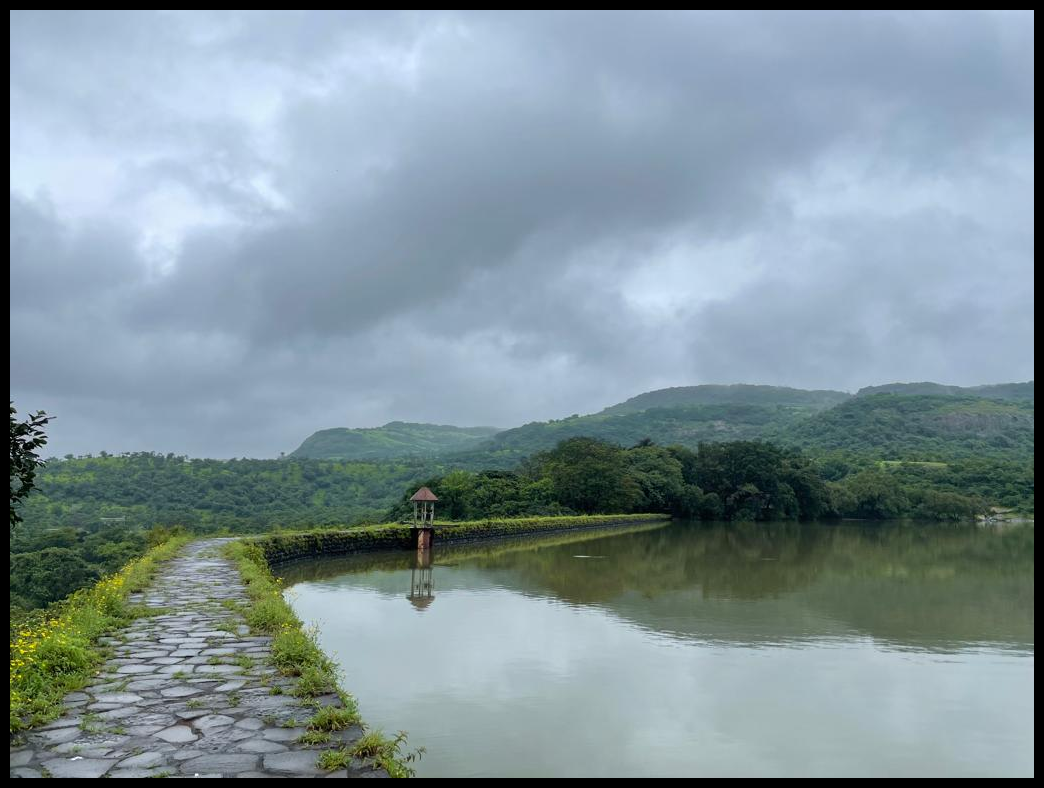

In [ ]:
cv2_imshow(zeroPadding0(img2,10))

We had to use an image of smaller size(less resolution) for this question as the code contains for loops which makes it ttake longer for execution.

We can clearly see a black border which corresponds to zero padding of width 10

Function to define Neighshrink of grayscale image or 1 channel of RGB image

In [ ]:
#A function is defined for image denoising by neighbouring wavelet coefficient.
def NeighShrink(pic,th,window_size=3):
  th_2 = th**2
  #here th is the threshold used and image will be the image that we have to denoise.
  #first we took the DWT of the image
  coeffs = pywt.dwt2(pic,'db4')
  #we use the direct function for dwt in 2D - dw2
  #we compute the DWT with db4 wavelet as it performs better as compared to haar 
  #the output is a tuple containing the Approximation, horizontal detail, 
  #vertical detail and diagonal detail coefficients respectively.
  LL, (LH, HL, HH) = coeffs

  #Applying NeighShrink thresholding
  #ideally threshold λ = 𝜎*sqrt(2*log2(l*w)) where 𝜎^2 = var = variance of noise in AWGN defined above
  # NeighShrink thresholds the wavelet coefficients according to the magnitude of the square sum of all the wavelet coefficients within the neighbourhood window.
  
  #defining a function for zeropadding as above
  def zeroPadding(image,d=int((window_size-1)/2)):#here d width of the 0 padding around the image
    L = image.shape[0]
    W = image.shape[1]
    if image.ndim == 2: #if images are grayscale, i.e, they only have rows and columns and no RGB channels
      zeroPad = np.zeros([L+2*d, W+2*d])#We create an array of 0s of size = size of required padded image
      zeroPad[d:L+d, d:W+d] = image ##We assign the inside pixels the value same as image
      return zeroPad #returning the thresholded grayscale image
    elif image.ndim == 3:
      if image.shape[2] == 3: #image is RGB - 3 channels
        zeroPad0 = np.zeros([L+2*d, W+2*d])#We create an array of 0s of size = size of required padded image
        zeroPad0[d:L+d, d:W+d] = image[:,:,0] ##We assign the inside pixels the value same as image in channel B

        zeroPad1 = np.zeros([L+2*d, W+2*d])#We create an array of 0s of size = size of required padded image
        zeroPad1[d:L+d, d:W+d] = image[:,:,1] ##We assign the inside pixels the value same as image in channel G

        zeroPad2 = np.zeros([L+2*d, W+2*d])#We create an array of 0s of size = size of required padded image
        zeroPad2[d:L+d, d:W+d] = image[:,:,2] ##We assign the inside pixels the value same as image in channel R

        #dealing with RGB channels separately

        #Source -> Numpy Docs
        zp_color = np.dstack((zeroPad0,zeroPad1,zeroPad2)) #np.dstack -> to stack r,g,b channels to create RGB image
        return zp_color
  
  #defining a function for changing the values of LH, HL and HH according to the neighbouring wavelet coefficint
  def thresholding(image):
    L = image.shape[0]
    W = image.shape[1]
    zp = zeroPadding(image)#zeropadding of the image
    a = int((window_size-1)/2)

    for i in range (a,L+a):
      for j in range (a,W+a):# the first 2 for loops are for centre of window running on image
        for m in range(window_size):
          for n in range(window_size):#these 2 for loops are for getting the sum of square of 
            # all the values in window and add them and assign it to centre pixel of window
            S_sq = 0
            S_sq = S_sq + zp[(i+m-1),(j+n-1)]**2 #adding the square of elements in window to our pre-defined variable S_sq
        
        if abs(S_sq) < abs(th_2): #the condition when b<0, we multiply the pixel by 0
          image[i-a,j-a] = 0
        else: #the condition when b > 0, we multiply the pixel by b
          image[i-a,j-a] = image[i-a,j-a] * (1 - (th_2/S_sq))
    return image #this will be the transformed LH/HL/HH with values equal to bij

    
  #getting modified LH,HL and HH
  LH=thresholding(LH)
  HL=thresholding(HL)
  HH=thresholding(HH)
  #defining the coefficients after thresholding
  coeffs = LL, (LH, HL, HH)

  fimage = pywt.idwt2(coeffs, 'db4')#taking IDWT 
  final = np.clip(fimage,0,255) #clip the image pixel intensities between 0-255 
  return final

Final function for Neighshrink Thresholding common for grayscale and colour images

In [ ]:
  #Now differentiating between grayscale and colour images
  def NeighShrink_th(pic,th,window_size=3):
  #We differentiate them on the basis of their dimensions as done in SSIM
    if pic.ndim == 2: #if images are grayscale, i.e, they only have rows and columns and no RGB channels
      return NeighShrink(pic,th,window_size) #returning the thresholded grayscale image
    elif pic.ndim == 3:
      NS1 = NeighShrink(pic[:,:,0],th,window_size)
      NS2 = NeighShrink(pic[:,:,1],th,window_size)
      NS3 = NeighShrink(pic[:,:,2],th,window_size)
      #dealing with RGB channels separately

      #Source -> Numpy Docs
      NS_color = np.dstack((NS1,NS2,NS3)) #np.dstack -> to stack r,g,b channels to create RGB image
      return NS_color
      #returning the thresholded colour image 

(768, 1024)
786432
62.58588099678898


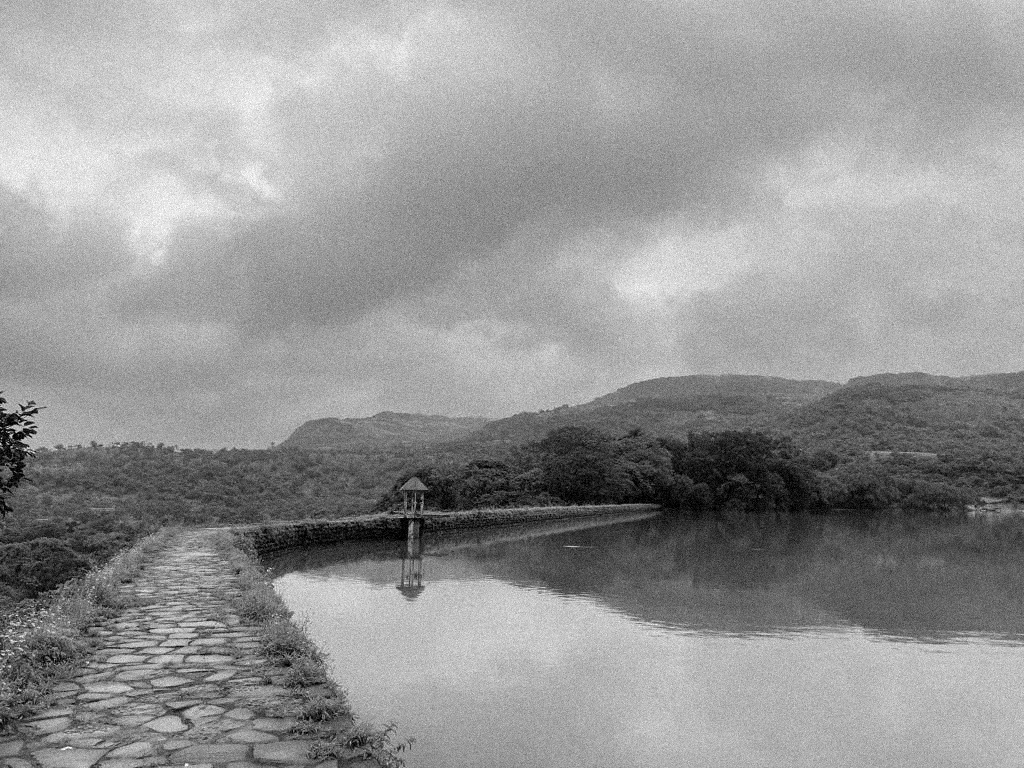

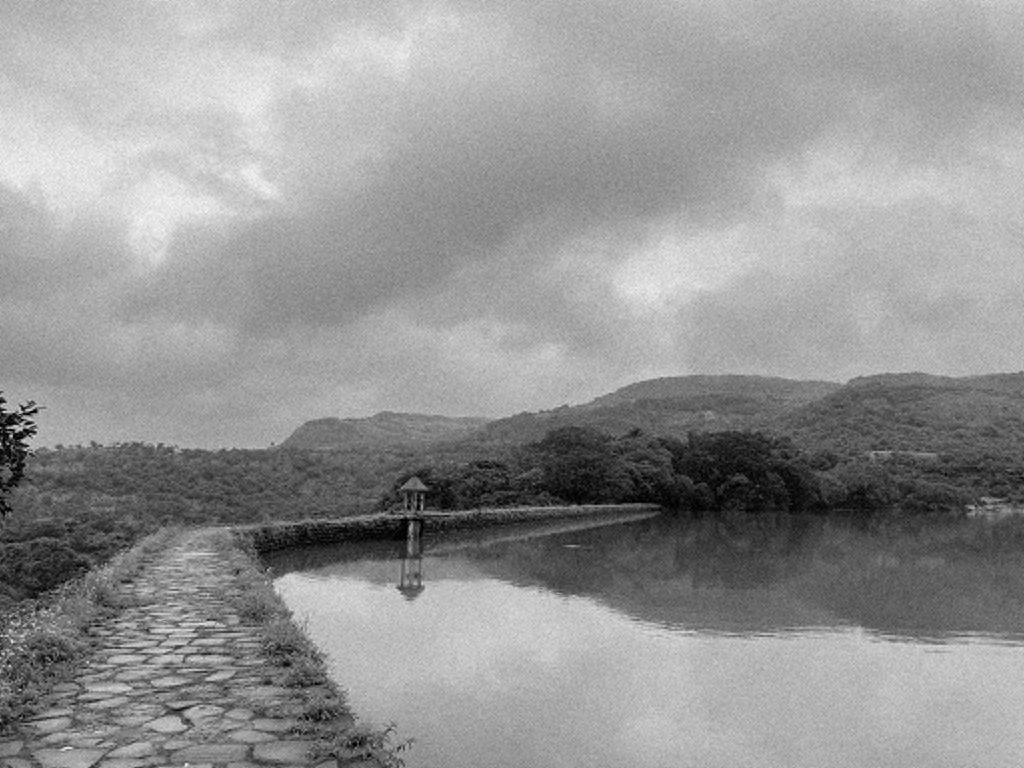

In [ ]:
var = 100
print(gray2.shape)
print(gray2.size)
th= np.sqrt(var*2*math.log2(Gaussian(gray2,var).size)) #t = lambda^2 which is the ideal threshold
print(th)
Neighshrink1 = NeighShrink_th(Gaussian(gray2,var),th) #hardthresholding the noisy image
#comparing the two images
cv2_imshow(Gaussian(gray2,var)) 
cv2_imshow(Neighshrink1)
#print(Neighshrink1[:,:-1]-Gaussian(gray2,var)) 

We observe that the sharp noise gets reduced but also, we lose certain details in the image

In [ ]:
cv2_imshow(Gaussian(img2,var))
cv2_imshow(NeighShrink_th(Gaussian(img2,var),th))

We can clearly see that the image is denoised, although details are lost, but our code works successfully for coloured images as well ...yayyy :)

# 3. Compare PSNR and SSIM (with plots) when you vary the noise added to clean color images by varying:

#a. Noise variance

Computing PSNRs

In [ ]:
x_p = np.linspace(0,1500,151) #We define and array for equally spaced variance array from 0-1000 in gaps of 10
y_p = []
for i in range(151):
  y_p.append(PSNR(img,Gaussian(img,x_p[i]))) 
#y_p -> array containing values of PSNRs for given variances in array x_p

Computing SSIMs

In [ ]:
x_s = np.linspace(0,1500,151) #We define an array equally spaced variance array from 0-1000 in gaps of 10
y_s=[]
for j in range(151):
  y_s.append(SSIM(img,Gaussian(img,x_s[j]))[1])
#y_s -> array containing values of SSIMs for given variances in array x_s

Comparing PSNRs and SSIMs

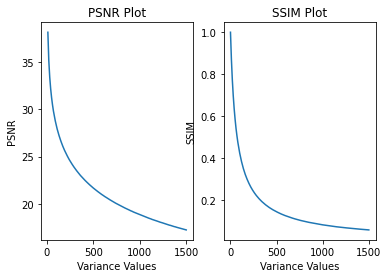

In [ ]:
plt.subplot(121)
plt.plot(x_p,y_p)
plt.title('PSNR Plot')
plt.xlabel('Variance Values')
plt.ylabel('PSNR')

plt.subplot(122)
plt.plot(x_s,y_s)
plt.title('SSIM Plot')
plt.xlabel('Variance Values')
plt.ylabel('SSIM')
plt.show()

We observe that the plot of PSNR exponentially decays as the variance of noise increases. It is infinite at 0 and approches 0 as variance is large.

For the SSIM plot, we observe that, it starts from 1 at similar images, decays exponentially with variance and approaches 0 as the variance increases.

**If seen the magnitude of decrease when they are plotted on same graph, PSNR surely decreases by greater magnitude as it decreases from infi to 0, while SSIM goes from 1 to 0. But, if seen the percentage change/rate of change wrt previous value, SSIM decays faster.**

**Conclusion -> We see that SSIM decays faster than the PSNR for increasing noise variance**

#b. Gaussian low pass filtering with various variances

In [ ]:
x_g = np.linspace(1,31,31) #We define and array for equally spaced variance array from 1-51 in gaps of 1
y_gp = []
y_gs = []
for i in range(31):
  y_gp.append(PSNR(img,gauss_blurr(img,x_g[i]))) 
#y_gp -> array containing values of PSNRs for given variances in array x_g
for j in range(31):
  y_gs.append(SSIM(img,gauss_blurr(img,x_g[j]))[1]) 
#y_gs -> array containing values of SSIMs for given variances in array x_g

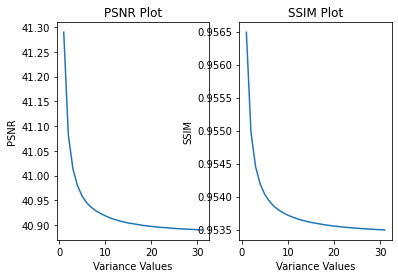

In [ ]:
plt.subplot(121)
plt.plot(x_g,y_gp)
plt.title('PSNR Plot')
plt.xlabel('Variance Values')
plt.ylabel('PSNR')

plt.subplot(122)
plt.plot(x_g,y_gs)
plt.title('SSIM Plot')
plt.xlabel('Variance Values')
plt.ylabel('SSIM')

plt.show()

We observe that the plot of PSNR exponentially decays as the variance of noise increases. It is infinite at 0 and approches 0 as variance is large.

For the SSIM plot, we observe that, it starts from 1 at similar images, decays exponentially with variance and approaches 0 as the variance increases.

**Conclusion -> We see that PSNR decays faster than the SSIM for increasing variance in Gaussian blurring**

#c. The two thresholding methods, where threshold is given by λ = 𝜎*sqrt(2*log2(𝑛^2))

For Hard Thresholding:

In [ ]:
x_thp = np.linspace(1,1000,100) #We define and array for equally spaced variance array from 0-1000 in gaps of 20
x_ths = np.linspace(0,1000,51) #We define and array for equally spaced variance array from 0-1000 in gaps of 20
y_htp = []
y_hts=[]
size = img.size/3 #we divide by 3 as the 3 of RGB channel also gets multiplied in size
for p in range(100):
  y_htp.append(PSNR(img,hardThreshold(Gaussian(img,x_thp[p]),math.sqrt(x_thp[p]*2*math.log2(size))))) 
  #equating our threshold λ = 𝜎sqrt(2log2(𝑛^2))
  #y_htp -> array containing values of PSNRs for given noisy image and
  #denoised image using Hard thresholding at different variances for both of them in array x_thp
for q in range(51):
  y_hts.append(SSIM(img,hardThreshold(Gaussian(img,x_ths[q]),math.sqrt(x_ths[q]*2*math.log2(size))))[1]) 
  #equating our threshold λ = 𝜎sqrt(2log2(𝑛^2))
  #y_hts -> array containing values of SSIMs for given noisy image and
  #denoised image using Hard thresholding at different variances for both of them in array x_ths

For Soft Thresholding

In [ ]:
y_stp = []
y_sts=[]
size = img.size/3 #we divide by 3 as the 3 of RGB channel also gets multiplied in size
for r in range(100):
  y_stp.append(PSNR(img,softThreshold(Gaussian(img,x_thp[r]),math.sqrt(x_thp[r]*2*math.log2(size))))) 
  #equating our threshold λ = 𝜎sqrt(2log2(𝑛^2))
  #y_stp -> array containing values of PSNRs for given noisy image and
  #denoised image using Soft thresholding at different variances for both of them in array x_th
for s in range(51):
  y_sts.append(SSIM(img,softThreshold(Gaussian(img,x_ths[s]),math.sqrt(x_ths[s]*2*math.log2(size))))[1]) 
  #equating our threshold λ = 𝜎sqrt(2log2(𝑛^2))
  #y_hts -> array containing values of SSIMs for given noisy image and
  #denoised image using Soft thresholding at different variances for both of them in array x_th

Displaying the graphs for all of Hard and Soft respectively

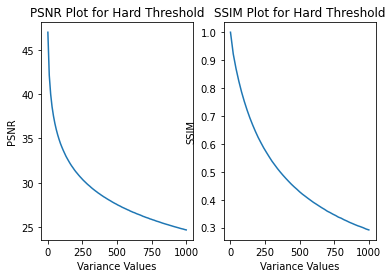

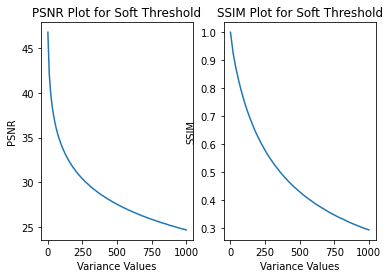

In [ ]:
#For Hard Thresholding
plt.subplot(121)
plt.plot(x_thp,y_htp)
plt.title('PSNR Plot for Hard Threshold')
plt.xlabel('Variance Values')
plt.ylabel('PSNR')

plt.subplot(122)
plt.plot(x_ths,y_hts)
plt.title('SSIM Plot for Hard Threshold')
plt.xlabel('Variance Values')
plt.ylabel('SSIM')

plt.show()

#For Soft Thresholding
plt.subplot(121)
plt.plot(x_thp,y_stp)
plt.title('PSNR Plot for Soft Threshold')
plt.xlabel('Variance Values')
plt.ylabel('PSNR')

plt.subplot(122)
plt.plot(x_ths,y_sts)
plt.title('SSIM Plot for Soft Threshold')
plt.xlabel('Variance Values')
plt.ylabel('SSIM')

plt.show()

We observe that the graph for PSNR decays more rapidly as compared with SSIM which decreases gradually for both Hard and Soft thresholding.

We also observe the value of PSNR and SSIM decays faster for Soft Thresholding than Hard Thresholding. Thus, we conclude that Hard Thresholding gives better results as it retains PSNR and SSIM more as compared to SSIM as the variance increases.

**Conclusion 1 - PSNR decays faster than SSIM for both threasholding**

**Conclusion 2 - Hard thresholding gives better results than Soft thresholding**

#d. The method of Chen et al.

In [ ]:
x_c = np.linspace(1,101,11) #We define and array for equally spaced variance array from 1-101 in gaps of 10
thc = []
y_cp = []
y_cs = []

for i in range(11):
  thc.append(math.sqrt(x_c[i]*2*math.log2(img2.size/3)))
for x in range(11):
  y_cp.append(PSNR(img2,NeighShrink_th(Gaussian(img2,x_c[x]),thc[x]))) 
#y_cp -> array containing values of PSNRs for given variances in array x_c
for y in range(11):
  y_cs.append(SSIM(img2,NeighShrink_th(Gaussian(img2,x_c[y]),thc[y]))[1]) 
#y_cs -> array containing values of SSIMs for given variances in array x_c

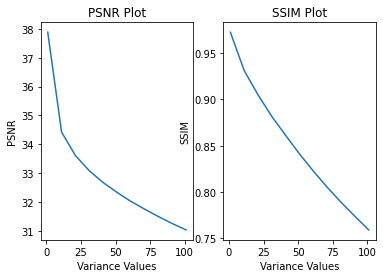

In [ ]:
#For Neighshrink Thresholding
plt.subplot(121)
plt.plot(x_c,y_cp)
plt.title('PSNR Plot')
plt.xlabel('Variance Values')
plt.ylabel('PSNR')

plt.subplot(122)
plt.plot(x_c,y_cs)
plt.title('SSIM Plot')
plt.xlabel('Variance Values')
plt.ylabel('SSIM')

plt.show()

We observe that the graph for PSNR decays much rapidly as compared with SSIM which decreases almost uniformly and gradually for NeighShrink

**Conclusion 1 - PSNR decays faster than SSIM for both NeighShrink and approaches zero faster for less variance**

#e. When the method is independently applied to RGB channels, versus when the method is applied to I channel of HSI transform.

First, we will need a function to convert RGB to HSI model

In [ ]:
#Source -> https://github.com/SVLaursen/Python-RGB-to-HSI/blob/master/converter.py
def RGB_HSI(image): 

    with np.errstate(divide='ignore', invalid='ignore'): 
    #np.errstate - allows statements in that context to execute with a known error handling behavior
    #Each keyword should have a string value that defines the treatment for the particular error

        #Load image with 32 bit floats as variable type
        BGR = np.float32(image)/255

        #Separating the color channels
        B = BGR[:,:,0]
        G = BGR[:,:,1]
        R = BGR[:,:,2]

        #Function to calculate Intensity
        def intensity(red, blue, green):
            return np.divide(blue + green + red,3)

        #Function to calculate Saturation
        def saturation(red, blue, green):
            min = np.minimum(red, green, blue) 
            sat = 1 - (3 * min / (red + green + blue))
            return sat

        #Function to calculate Hue
        def hue(red, blue, green):
            hue = np.copy(red) #to create an array with similar dimensions as the image

            #computing the value of theta
            for i in range(0, blue.shape[0]):
                for j in range(0, blue.shape[1]):
                    hue[i][j] = 0.5 * ((red[i][j] - green[i][j]) + (red[i][j] - blue[i][j])) / \
                                math.sqrt((red[i][j] - green[i][j])**2 +
                                        ((red[i][j] - blue[i][j]) * (green[i][j] - blue[i][j])))
                    hue[i][j] = math.acos(hue[i][j])
                    #if B<=G then the value of Hue is theta itself
                    if blue[i][j] <= green[i][j]:
                        hue[i][j] = hue[i][j]
                    #otherwise, the value of Hue is (360 - theta) in radian
                    else:
                        hue[i][j] = ((360 * math.pi) / 180.0) - hue[i][j]

            return hue

        #Merge channels into picture and return image
        HSI = cv2.merge((hue(R,B,G), saturation(R,B,G), intensity(R,B,G)))
        return HSI

In [ ]:
#Converting our img2 to HSI
hsi = RGB_HSI(img2)
print(hsi)

[[[3.6780207  0.04489791 0.6405229 ]
  [3.6780207  0.04489791 0.6405229 ]
  [3.6780207  0.04489791 0.6405229 ]
  ...
  [3.7509687  0.03552407 0.7359478 ]
  [3.7509687  0.03552407 0.7359478 ]
  [3.7509687  0.03552407 0.7359478 ]]

 [[3.6780207  0.04489791 0.6405229 ]
  [3.6780207  0.04489791 0.6405229 ]
  [3.6780207  0.04489791 0.6405229 ]
  ...
  [3.7509687  0.03571427 0.73202616]
  [3.7509687  0.03552407 0.7359478 ]
  [3.7509687  0.03552407 0.7359478 ]]

 [[3.6780207  0.04489791 0.6405229 ]
  [3.6780207  0.04489791 0.6405229 ]
  [3.6780207  0.04489791 0.6405229 ]
  ...
  [3.7509687  0.03571427 0.73202616]
  [3.7509687  0.03571427 0.73202616]
  [3.7509687  0.03571427 0.73202616]]

 ...

 [[3.28494    0.05500001 0.26143792]
  [3.2849402  0.04602504 0.3124183 ]
  [3.2849402  0.04330713 0.33202615]
  ...
  [3.1415927  0.03409094 0.6901961 ]
  [3.1415927  0.03409094 0.6901961 ]
  [3.1415927  0.03409094 0.6901961 ]]

 [[3.2849402  0.04721022 0.30457518]
  [3.2849402  0.04382461 0.3281046 ]


In [ ]:
#Defining I channel separately
I_ch = hsi[:,:,2] * 255 #We multiply by 255 as Intensity as it is normalized intensity
x_i = np.linspace(1,101,11) #We define and array for equally spaced variance array from 1-101 in gaps of 10
thi = []
y_cpi = []
y_csi = []

for i in range(11):
  thi.append(math.sqrt(x_i[i]*2*math.log2(I_ch.size)))
for x in range(11):
  y_cpi.append(PSNR(I_ch,NeighShrink_th(Gaussian(I_ch,x_i[x]),thi[x]))) 
#y_cp -> array containing values of PSNRs for given variances in array x_g
for y in range(11):
  y_csi.append(SSIM(I_ch,NeighShrink_th(Gaussian(I_ch,x_i[y]),thi[y]))) 
#y_gs -> array containing values of SSIMs for given variances in array x_g

Plotting the PSNR and SSIM graphs for RGB and HSI mode together

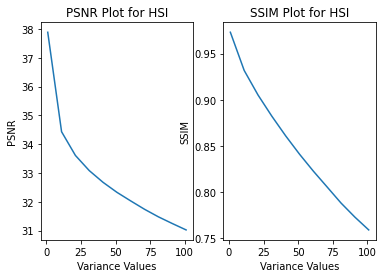

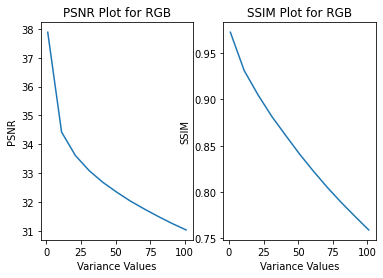

In [ ]:
#For HSI
plt.subplot(121)
plt.plot(x_i,y_cpi)
plt.title('PSNR Plot for HSI')
plt.xlabel('Variance Values')
plt.ylabel('PSNR')

plt.subplot(122)
plt.plot(x_i,y_csi)
plt.title('SSIM Plot for HSI')
plt.xlabel('Variance Values')
plt.ylabel('SSIM')

plt.show()

#For RGB
plt.subplot(121)
plt.plot(x_c,y_cp)
plt.title('PSNR Plot for RGB')
plt.xlabel('Variance Values')
plt.ylabel('PSNR')

plt.subplot(122)
plt.plot(x_c,y_cs)
plt.title('SSIM Plot for RGB')
plt.xlabel('Variance Values')
plt.ylabel('SSIM')

plt.show()

We observe see the same conclusion as above that PSNR approaches 0 faster as compared to SSIM. Also, the plots when NeighShrink is applied to separate RGB channels and when NeighShrunk is applied to I channel in HSI gives the same result, i.e, the plots are same.

**Conclusion -  NeighShrink applied to separate RGB channels and NeighShrunk applied to I channel in HSI gives the same result as I = (R+B+G)/3 and applied NeighShrink to I is same as applied it to R,G,B**

# 4. Compare a few of the methods from part 3 on real noisy images, where noise variance is not known, by assuming various values of the noise variance as trial and error.

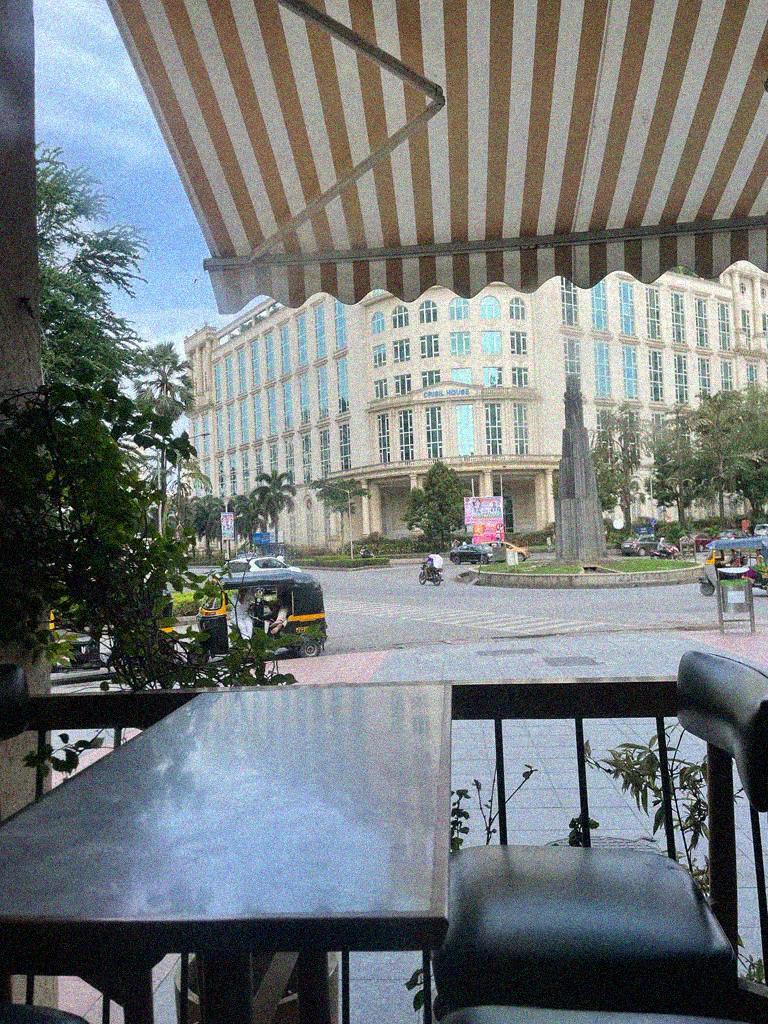

In [ ]:
Noisy = cv2.imread('/content/drive/MyDrive/EE610/Assignment3/noisyimg.jpeg') #to read our real noisy image
cv2_imshow(Noisy) #to display the image

We will check the two thresholding methods and Chen Et Al method

In [ ]:
var_arr = [100,200,300,400,500] #Value of variances we will check at
th4=[]
for j in range(5):
  th4.append(np.sqrt(var_arr[j]*2*math.log2(Noisy.size/3)))

Observing Hard Thresholding results at different Variances

In [ ]:
psnr_ht = []
ssim_ht =[]
print("Hard Thresholding")
for i in range(5):
  cv2_imshow(hardThreshold(Noisy,th4[i]))
  psnr_ht.append(PSNR(Noisy,hardThreshold(Noisy,th4[i])))
  ssim_ht.append(SSIM(Noisy,hardThreshold(Noisy,th4[i]))[1])

Observing Soft Thresholding results at different Variances

In [ ]:
psnr_st = []
ssim_st =[]
print("Soft Thresholding")
for i in range(5):
  cv2_imshow(softThreshold(Noisy,th4[i]))
  psnr_st.append(PSNR(Noisy,softThreshold(Noisy,th4[i])))
  ssim_st.append(SSIM(Noisy,softThreshold(Noisy,th4[i]))[1])

Observing NeighShrink results at different Variances

In [ ]:
psnr_ns = []
ssim_ns =[]
print("Chen Et Al")
for i in range(5):
  cv2_imshow(NeighShrink_th(Noisy,th4[i]))
  psnr_ns.append(PSNR(Noisy,NeighShrink_th(Noisy,th4[i])))
  ssim_ns.append(SSIM(Noisy,NeighShrink_th(Noisy,th4[i]))[1])

Visually, we observe that better results at var = 300. Also, we find that, NeighShrink looks visually slightly better than soft Thresholding and Hard thresholding.
To confirm our observation, we plot PSNR plots and SSIM plots for each of the above methods for all variances.

#Plots for different variances

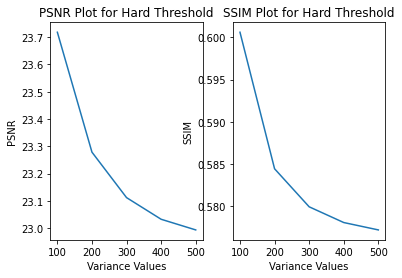

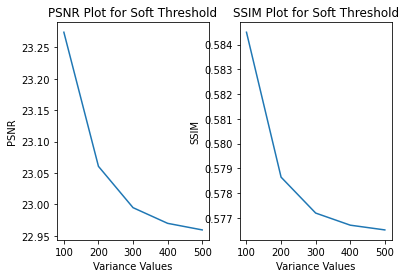

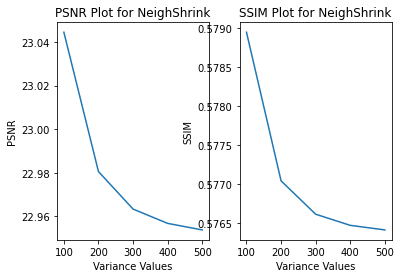

In [ ]:
#For Hard Thresholding
plt.subplot(121)
plt.plot(var_arr,psnr_ht)
plt.title('PSNR Plot for Hard Threshold')
plt.xlabel('Variance Values')
plt.ylabel('PSNR')

plt.subplot(122)
plt.plot(var_arr,ssim_ht)
plt.title('SSIM Plot for Hard Threshold')
plt.xlabel('Variance Values')
plt.ylabel('SSIM')

plt.show()

#For Soft Thresholding
plt.subplot(121)
plt.plot(var_arr,psnr_st)
plt.title('PSNR Plot for Soft Threshold')
plt.xlabel('Variance Values')
plt.ylabel('PSNR')

plt.subplot(122)
plt.plot(var_arr,ssim_st)
plt.title('SSIM Plot for Soft Threshold')
plt.xlabel('Variance Values')
plt.ylabel('SSIM')

plt.show()

#For NeighShrink
plt.subplot(121)
plt.plot(var_arr,psnr_ns)
plt.title('PSNR Plot for NeighShrink')
plt.xlabel('Variance Values')
plt.ylabel('PSNR')

plt.subplot(122)
plt.plot(var_arr,ssim_ns)
plt.title('SSIM Plot for NeighShrink')
plt.xlabel('Variance Values')
plt.ylabel('SSIM')

plt.show()

Conclusion - **For the graphs observed, NeighShrink is the best among the three**

#Assignment Completed